In [1]:
import numpy as np
import pandas as pd
from time import perf_counter
import matplotlib.pyplot as plt

In [2]:
def gauss_elimination(A, b, dtype=np.float16):
    n = len(A)
    A = A.astype(dtype)
    b = b.astype(dtype)
    for i in range(n):
        factor = A[i, i]
        A[i] /= factor
        b[i] /= factor

        for j in range(i+1, n):
            factor = A[j, i]
            A[j] -= factor * A[i]
            b[j] -= factor * b[i]

    for i in range(n-1, -1, -1):
        for j in range(i-1, -1, -1):
            factor = A[j, i]
            A[j] -= factor * A[i]
            b[j] -= factor * b[i]

    return b

In [3]:
def create_matrix_A(fn, n, dtype=np.float64):
    A = np.zeros((n, n), dtype=dtype)
    for i in range(n):
        for j in range(n):
            value  = fn(i, j)
            if value is not None:
                A[i, j] = value
            else:
                A[i,j] = A[j,i]
    return A

In [4]:
def create_tridiagonal_matrix(fn, n, dtype=np.float64):
    A = np.zeros((n, 3), dtype=dtype)
    for i in range(n):
        for j in range(3):
            k = i + j - 1
            if k >= 0 and k < n:
                A[i, j] = fn(i, k)
            else:
                A[i, j] = 0
    return A


In [5]:
def func1(i, j):
    if i+1 == 1:
        return 1
    return 1/(i+j+2-1)

In [6]:
def func2(i, j):
    if j>=i:
        return 2*(i+1)/(j+1)
    return None

In [7]:
def create_vector_x(n):
    x = np.array([1 if i % 2 == 0 else -1 for i in range(n)])
    return x

In [8]:
def calc_vector_b(x, A, dtype=np.float64,is_tridiagonal=False):
    if is_tridiagonal:
        n = len(A)
        b = np.zeros(n, dtype=dtype)
        for i in range(n):
            for j in range(3):
                k = i + j - 1
                if k >= 0 and k < n:
                    b[i] += A[i, j] * x[k]
        return b
    else:
        return np.dot(A, x).astype(dtype)

In [9]:
def solve_and_display_errors(error, ns, precisions, fn_to_calculate_A, sol_method="gauss"):
    errors = {precision: [] for precision, _ in precisions}
    is_tridiagonal = sol_method == "thomas"
    if sol_method == "gauss":
        sol_method = gauss_elimination
        create_matrix_method = create_matrix_A
    elif sol_method == "thomas":
        sol_method = thomas_algorithm
        create_matrix_method = create_tridiagonal_matrix
    for n in ns:
        x = create_vector_x(n)
        for precision_name, precision in precisions:
            A = create_matrix_method(fn_to_calculate_A, n, precision)
            b = calc_vector_b(x, A, precision, is_tridiagonal)
            x_calc = sol_method(A, b, precision)
            error_value = error(x, x_calc)
            errors[precision_name].append(error_value)
    errors_data = {
        'n': ns,
    }
    for precision, _ in precisions:
        errors_data[precision] = errors[precision]
    return errors_data

In [10]:
def data_plot(data, ns, x_label="", y_label="", title="", to_display=[], labels=[], colors=[], figsize=(16,9), \
    legend_size=20):
    fig, ax = plt.subplots(figsize=figsize)
    if len(to_display) > 0:
        for index, label in enumerate(to_display):
            if index < len(colors):
                ax.scatter(ns, data[label], label=labels[index], color=colors[index])
            else:
                ax.scatter(ns, data[label], label=labels[index])
    else:
        for label in data.keys():
            if label != 'n':
                ax.scatter(ns, data[label], label=label)
    # for label in data.keys():
    #     if label != 'n' and (len(to_display) == 0 or label in to_display):
    #         ax.scatter(ns, data[label], label=label)

    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    ax.legend(loc='best', prop={'size': legend_size})
    ax.title.set_size(20)
    ax.xaxis.label.set_size(17)
    ax.yaxis.label.set_size(17)

    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.show()

In [11]:
def solve_and_display_times(error, ns, precision, fn_to_calculate_A):
    errors = {"gauss": [], "thomas": []}
    times = {"gauss_time [s]": [], "thomas_time [s]": []}
    for n in ns:
        x = create_vector_x(n)
        A_gauss = create_matrix_A(fn_to_calculate_A, n, precision)
        A_thomas = create_tridiagonal_matrix(fn_to_calculate_A, n, precision)
        b_gauss = calc_vector_b(x, A_gauss, precision)
        b_thomas = calc_vector_b(x, A_thomas, precision, is_tridiagonal=True)
        g_time_start = perf_counter()
        x_gauss = gauss_elimination(A_gauss, b_gauss, precision)
        g_time_end = perf_counter()

        t_time_start = perf_counter()
        x_thomas = thomas_algorithm(A_thomas, b_thomas, precision)
        t_time_end = perf_counter()

        g_time_duration = g_time_end - g_time_start
        t_time_duration = t_time_end - t_time_start
        times["gauss_time [s]"].append(g_time_duration)
        times["thomas_time [s]"].append(t_time_duration)
        g_error_value = error(x, x_gauss)
        errors["gauss"].append(g_error_value)
        t_error_value = error(x, x_thomas)
        errors["thomas"].append(t_error_value)
        data = {
            'n': ns,
            'gauss_time [s]': times["gauss_time [s]"],
            'thomas_time [s]': times["thomas_time [s]"],
            'gauss_error': errors["gauss"],
            'thomas_error': errors["thomas"]
        }
    return data

In [12]:
def max_error(x, x_calc):
    return max(abs(x - x_calc))

In [13]:
def norm_diffrence(x, x_calc):
    return np.linalg.norm(x - x_calc)

In [14]:
def create_table(data, n_list=None):
    df = pd.DataFrame(data)
    if n_list is not None:
        df = df[df['n'].isin(n_list)]
    display(df)


In [15]:
def check_conditioning_factor(A):
    conditioning = np.linalg.cond(A)
    return conditioning

In [16]:
def compare_conditioning_factors(ns):
    A1s = [create_matrix_A(func1, n) for n in ns]
    A2s = [create_matrix_A(func2, n) for n in ns]
    conditioning_factors = {
        'n': ns,
        'func1': [check_conditioning_factor(A) for A in A1s],
        'func2': [check_conditioning_factor(A) for A in A2s]
    }
    # df = create_table(conditioning_factors)
    # display(df)
    return conditioning_factors


In [17]:
#Zadanie 3

In [18]:
k=7
m=4

In [19]:
def thomas_algorithm_not_modified_A(A, b, dtype=np.float16):
    n = len(A)
    A = A.astype(dtype)
    b = b.astype(dtype)
    c = np.zeros(n, dtype=dtype)
    d = np.zeros(n, dtype=dtype)
    x = np.zeros(n, dtype=dtype)
    c[0] = A[0, 1] / A[0, 0]
    d[0] = b[0] / A[0, 0]
    for i in range(1, n-1):
        c[i] = A[i, i+1] / (A[i, i] - A[i, i-1] * c[i-1])
    for i in range(1, n):
        d[i] = (b[i] - A[i, i-1] * d[i-1]) / (A[i, i] - A[i, i-1] * c[i-1])
    x[n-1] = d[n-1]
    for i in range(n-2, -1, -1):
        x[i] = d[i] - c[i] * x[i+1]
    return x
def thomas_algorithm(A, b, dtype=np.float64):
    n = len(A)
    A = A.astype(dtype)
    b = b.astype(dtype)
    c = np.zeros(n, dtype=dtype)
    d = np.zeros(n, dtype=dtype)
    x = np.zeros(n, dtype=dtype)
    c[0] = A[0, 2] / A[0, 1]
    d[0] = b[0] / A[0, 1]
    for i in range(1, n-1):
        c[i] = A[i, 2] / (A[i, 1] - A[i, 0] * c[i-1])
    for i in range(1, n):
        d[i] = (b[i] - A[i, 0] * d[i-1]) / (A[i, 1] - A[i, 0] * c[i-1])
    x[n-1] = d[n-1]
    for i in range(n-2, -1, -1):
        x[i] = d[i] - c[i] * x[i+1]
    return x

In [20]:
def func3(i, j):
    if i==j:
        return -m*(i+1)-k
    if i+1 == j:
        return i+1
    if j+1 == i and i >0:
        return m/i
    if j<i-1 or j>i+1:
        return 0
    return None

In [231]:
#Analiza

In [232]:
#Zadanie 1

In [22]:
ns = range(2, 201)
ns_table = [2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,50,75,100,150,200]
precisions = [("float32",np.float32), ("float64",np.float64)]

,n,float32,float64
0,2,0.000000,0.000000e+00
1,3,0.000002,0.000000e+00
2,4,0.000003,1.929568e-13
3,5,0.000317,6.979972e-12
4,6,0.044535,2.437184e-10
5,7,0.375060,8.735740e-09
6,8,1.606400,7.057528e-08
7,9,4.904638,5.060815e-07
8,10,5.521448,7.760520e-05
9,11,2.764232,6.263925e-03


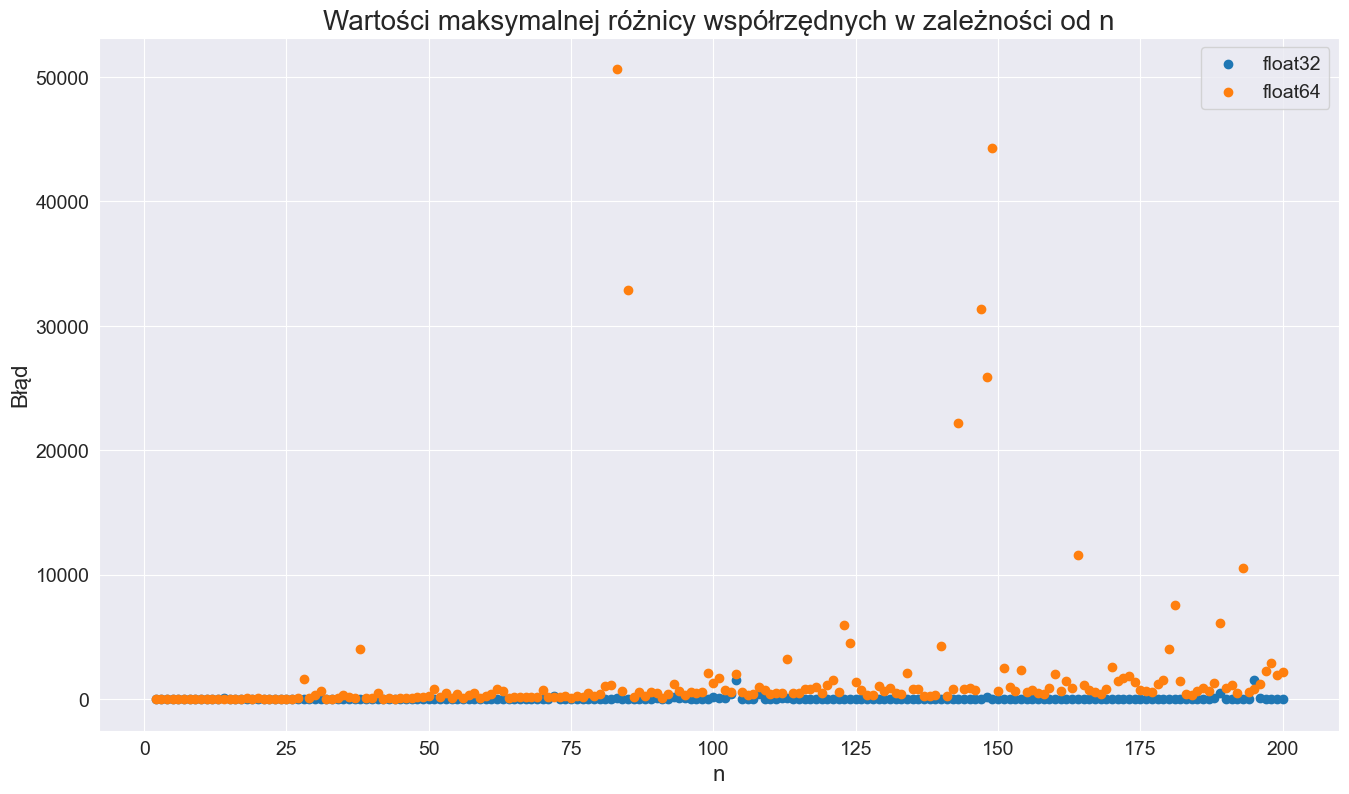

In [280]:
data = solve_and_display_errors(max_error, ns, precisions, func1)
create_table(data, ns_table)
data_plot(data, ns, "n", "Błąd", "Wartości maksymalnej różnicy współrzędnych w zależności od n")

,n,float32,float64
0,2,0.000000,0.000000e+00
1,3,0.000003,0.000000e+00
2,4,0.000004,2.465697e-13
3,5,0.000470,9.891256e-12
4,6,0.065090,3.568660e-10
5,7,0.540226,1.259790e-08
6,8,2.320680,1.062511e-07
7,9,8.689874,8.089723e-07
8,10,7.927493,1.225307e-04
9,11,4.330271,1.001833e-02


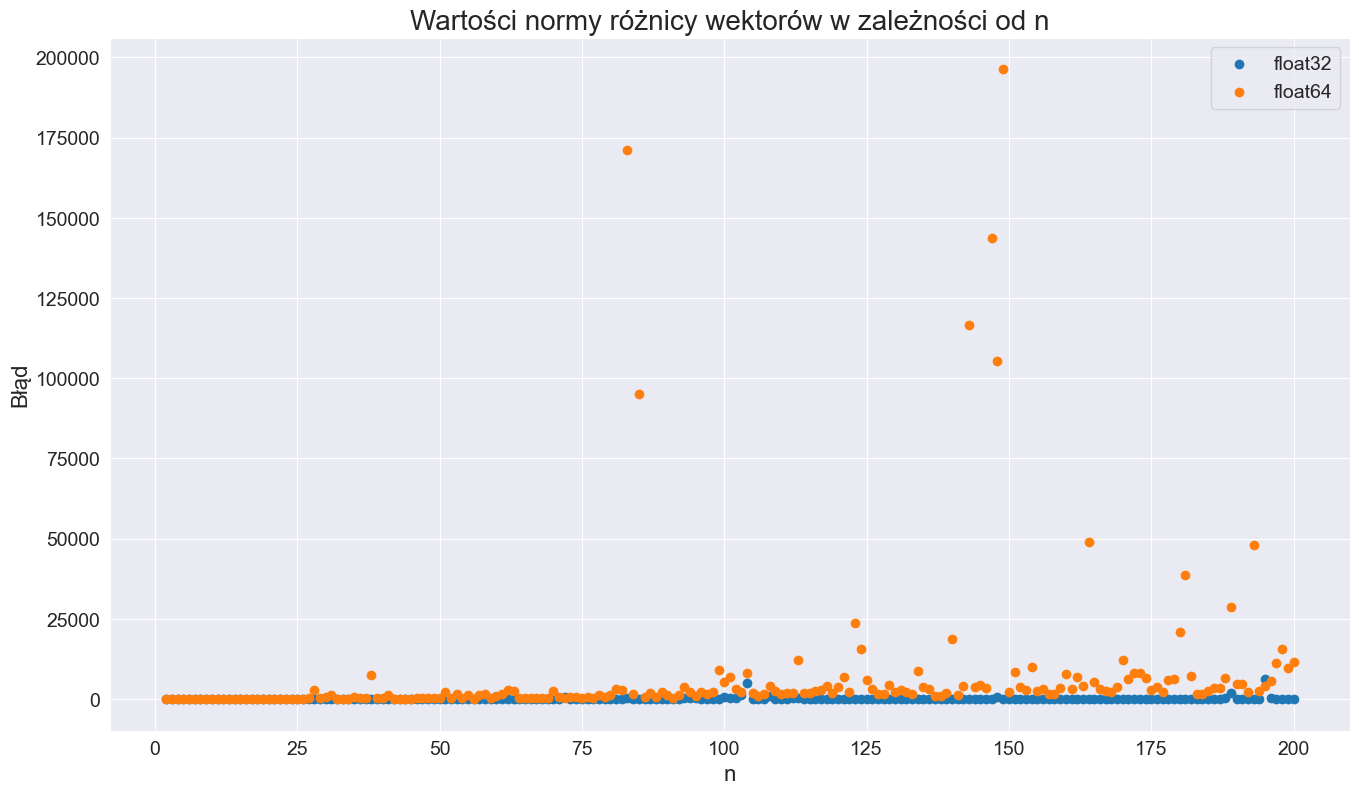

In [281]:
data = solve_and_display_errors(norm_diffrence, ns, precisions, func1)
create_table(data, ns_table)
data_plot(data, ns, "n", "Błąd", "Wartości normy różnicy wektorów w zależności od n")

In [236]:
#Zadanie 2

,n,float32,float64
0,2,0.000000e+00,0.000000e+00
1,3,1.192093e-07,2.220446e-16
2,4,1.192093e-07,2.220446e-16
3,5,1.192093e-07,2.220446e-16
4,6,2.384186e-07,4.440892e-16
5,7,1.013279e-06,6.661338e-16
6,8,1.132488e-06,4.551914e-15
7,9,1.013279e-06,2.331468e-15
8,10,2.920628e-06,2.331468e-15
9,11,2.563000e-06,4.218847e-15


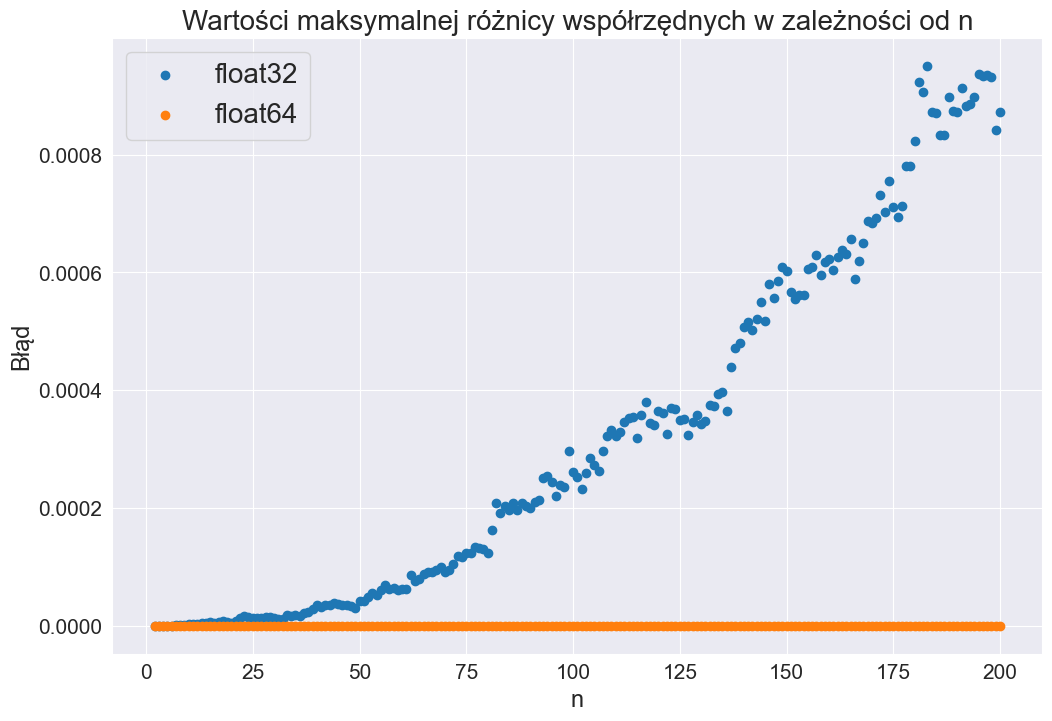

In [46]:
data = solve_and_display_errors(max_error, ns, precisions, func2)
create_table(data, ns_table)
data_plot(data, ns, "n", "Błąd", "Wartości maksymalnej różnicy współrzędnych w zależności od n", figsize=(12,8))

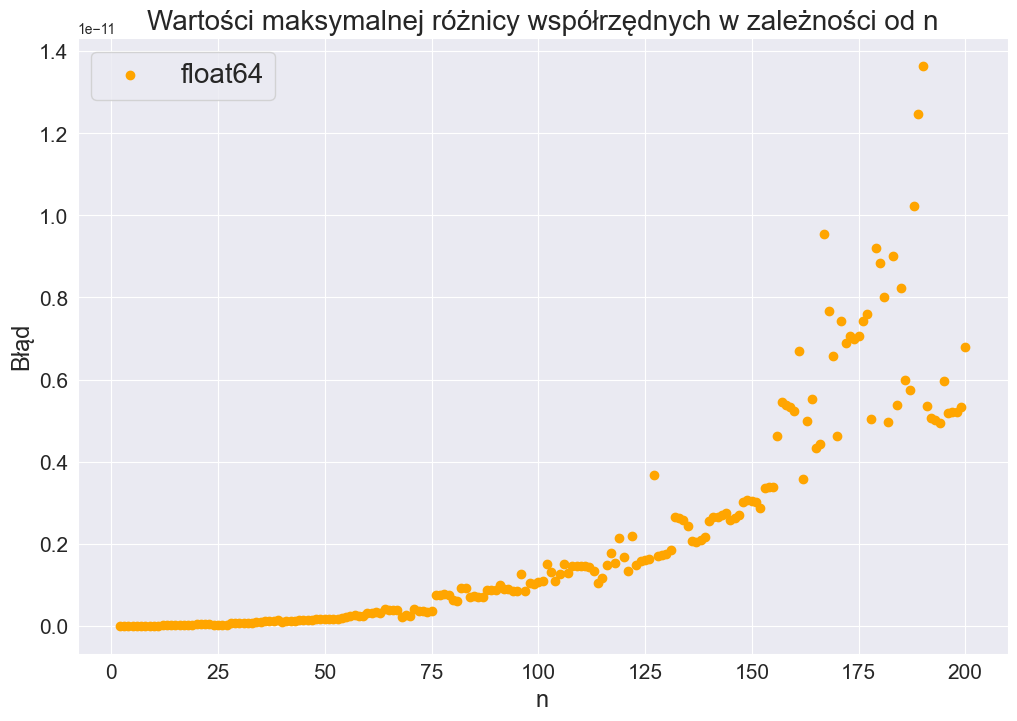

In [43]:
data_plot(data, ns, "n", "Błąd", "Wartości maksymalnej różnicy współrzędnych w zależności od n",
          to_display=["float64"],labels=["float64"], colors=["orange"], figsize=(12,8))

,n,float32,float64
0,2,0.000000e+00,0.000000e+00
1,3,1.192093e-07,2.482534e-16
2,4,1.332800e-07,2.482534e-16
3,5,2.149076e-07,3.330669e-16
4,6,3.039252e-07,5.978734e-16
5,7,1.231669e-06,8.950904e-16
6,8,1.383804e-06,5.564422e-15
7,9,1.233110e-06,2.817430e-15
8,10,4.336417e-06,3.306527e-15
9,11,3.729460e-06,6.745005e-15


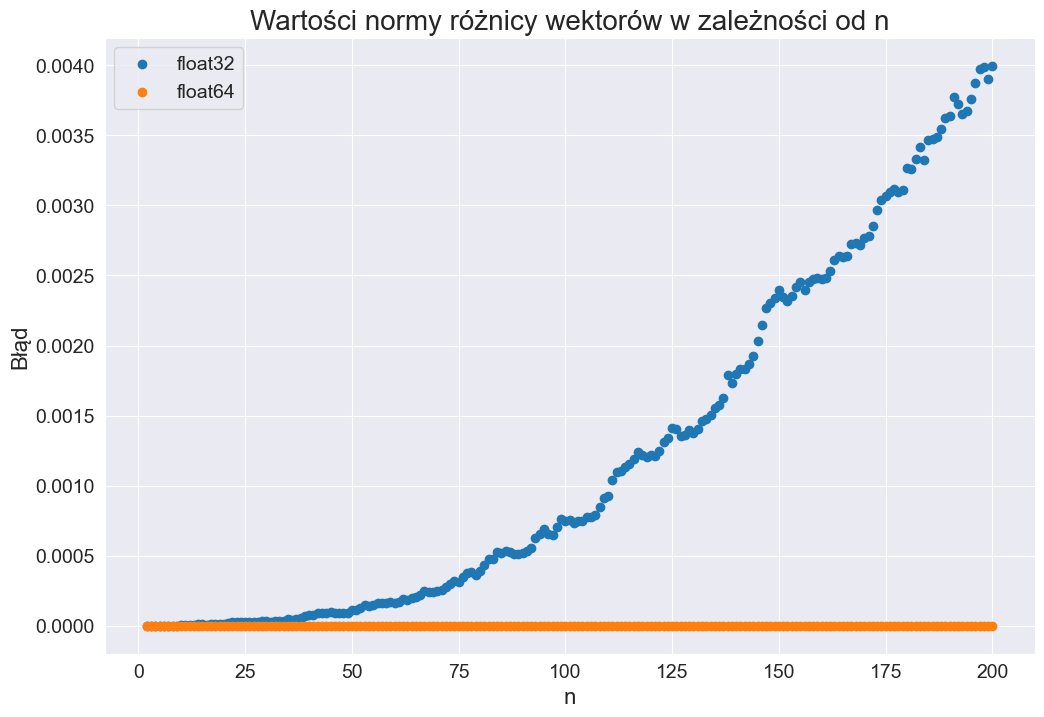

In [285]:
data = solve_and_display_errors(norm_diffrence, ns, precisions, func2)
create_table(data, ns_table)
data_plot(data, ns, "n", "Błąd", "Wartości normy różnicy wektorów w zależności od n", figsize=(12,8))

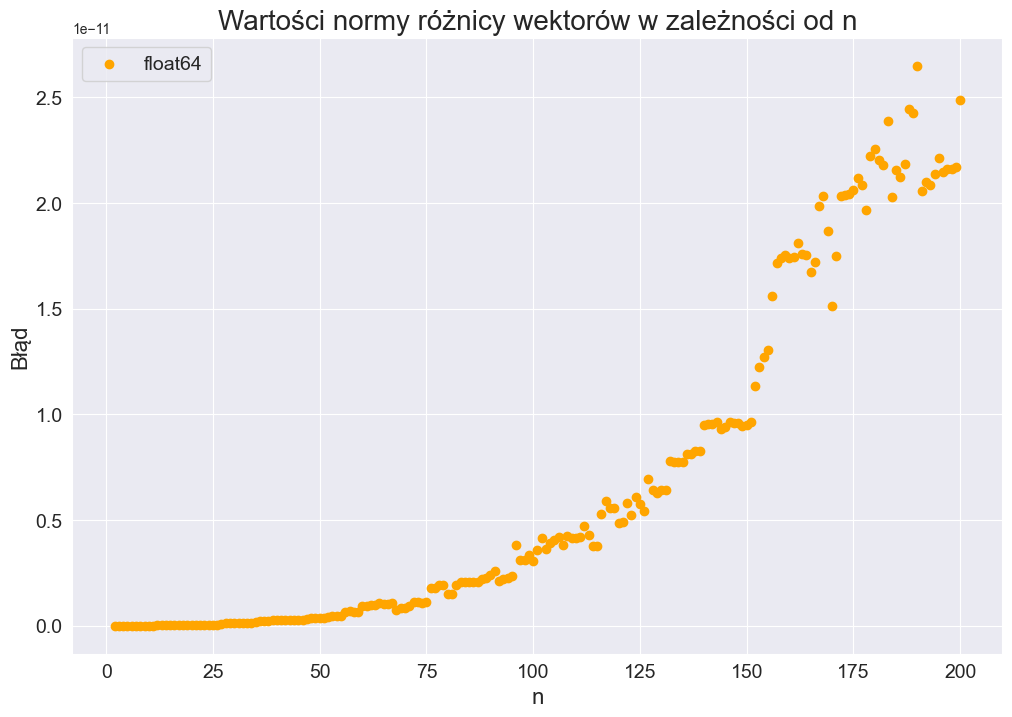

In [286]:
data_plot(data, ns, "n", "Błąd", "Wartości normy różnicy wektorów w zależności od n",
          to_display=["float64"], colors=["orange"], figsize=(12,8))

,n,func1,func2
0,2,1.409572e+01,3.000000
1,3,4.829221e+02,6.663295
2,4,1.703290e+04,12.206264
3,5,5.918771e+05,19.655490
4,6,2.037851e+07,29.040429
5,7,6.980461e+08,40.387341
6,8,2.383968e+10,53.717162
7,9,8.126917e+11,69.046612
8,10,2.767444e+13,86.389316
9,11,9.440475e+14,105.756602


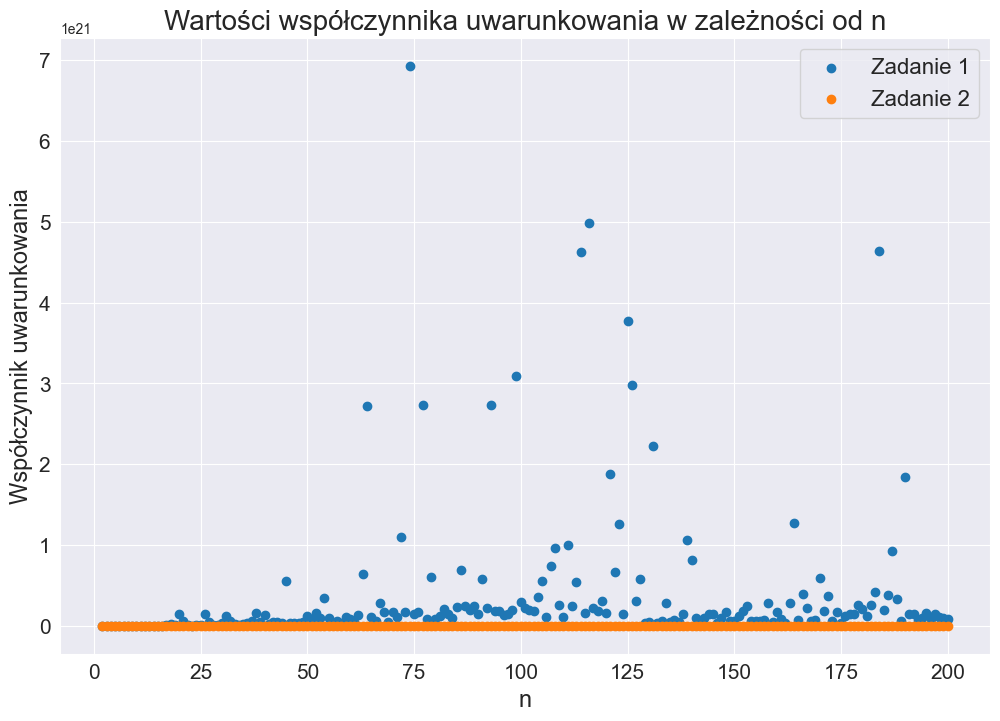

In [307]:
cond_factors = compare_conditioning_factors(ns)
create_table(cond_factors, ns_table)
data_plot(cond_factors, ns, "n", "Współczynnik uwarunkowania", "Wartości współczynnika uwarunkowania w zależności od "
                                                               "n", to_display=["func1", "func2"],labels=["Zadanie "
                                                                                                          "1",
                                                                                                          "Zadanie 2"] ,
          figsize=\
    (12,8),
          legend_size=16)

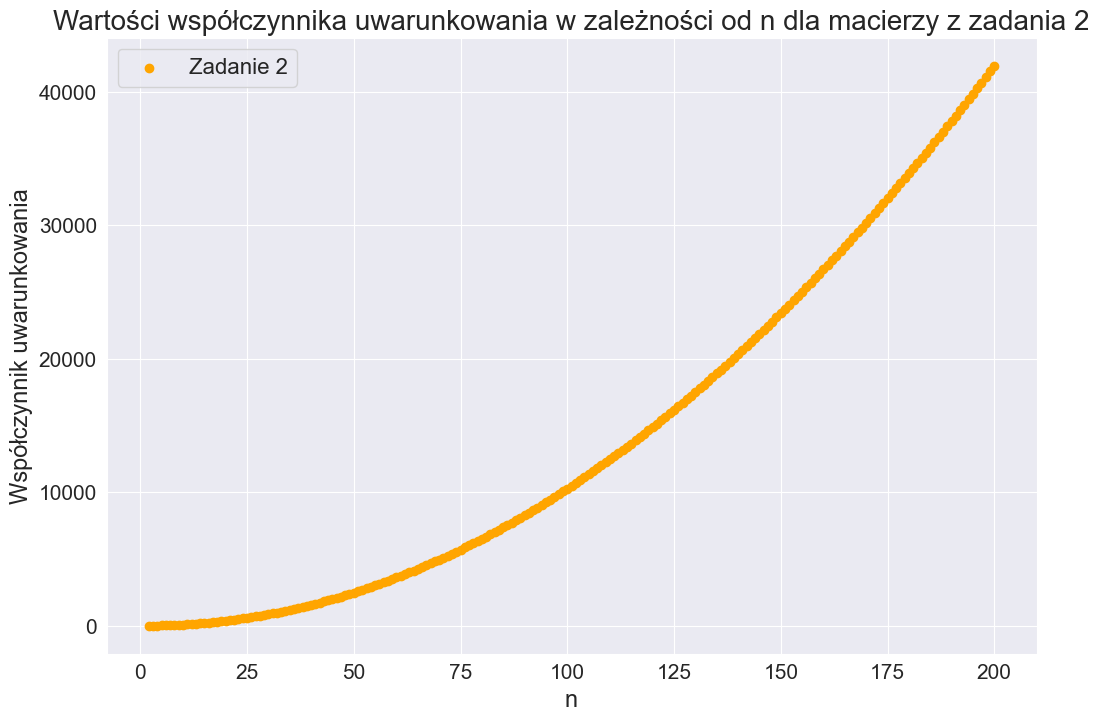

In [306]:
data_plot(cond_factors, ns, "n", "Współczynnik uwarunkowania", "Wartości współczynnika uwarunkowania w zależności od "
                                                               "n dla macierzy z zadania 2", to_display=["func2"],
          labels=["Zadanie 2"],
          colors=["orange"], figsize=(12,8), legend_size=16)

In [241]:
#Zadanie 3

,n,float32,float64
0,2,0.000000e+00,1.110223e-16
1,3,5.960464e-08,1.110223e-16
2,4,5.960464e-08,1.110223e-16
3,5,5.960464e-08,2.220446e-16
4,6,5.960464e-08,2.220446e-16
5,7,1.192093e-07,2.220446e-16
6,8,1.192093e-07,2.220446e-16
7,9,1.192093e-07,2.220446e-16
8,10,1.192093e-07,2.220446e-16
9,11,1.192093e-07,2.220446e-16


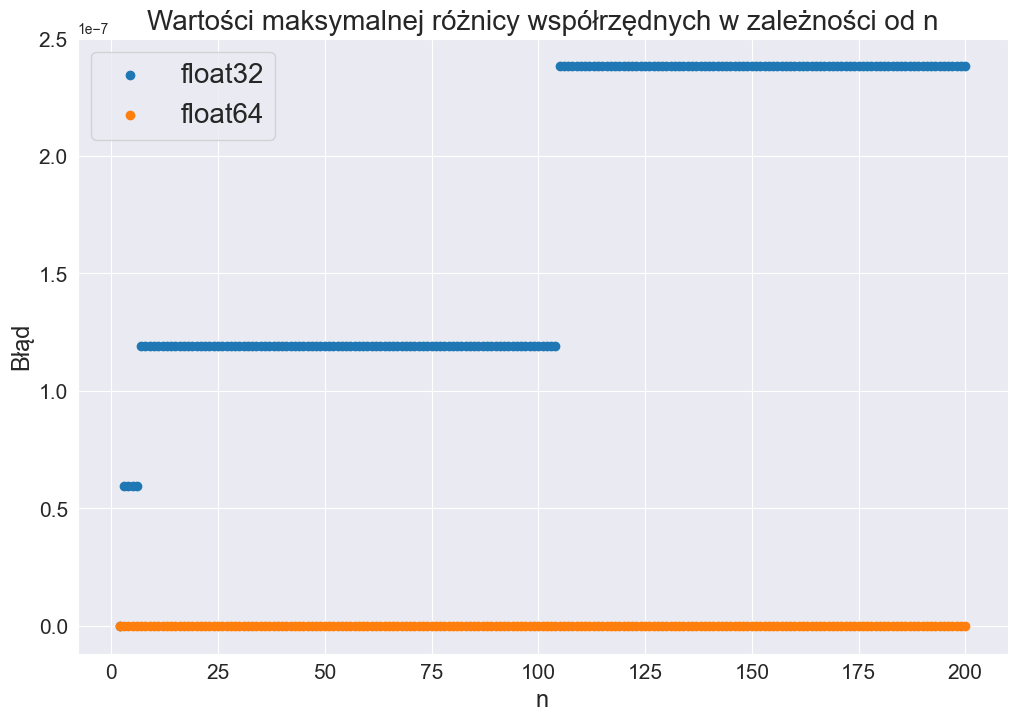

In [320]:
data = solve_and_display_errors(max_error, ns, precisions, func3)
create_table(data, ns_table)
data_plot(data, ns, "n", "Błąd", "Wartości maksymalnej różnicy współrzędnych w zależności od n", figsize=(12,8))

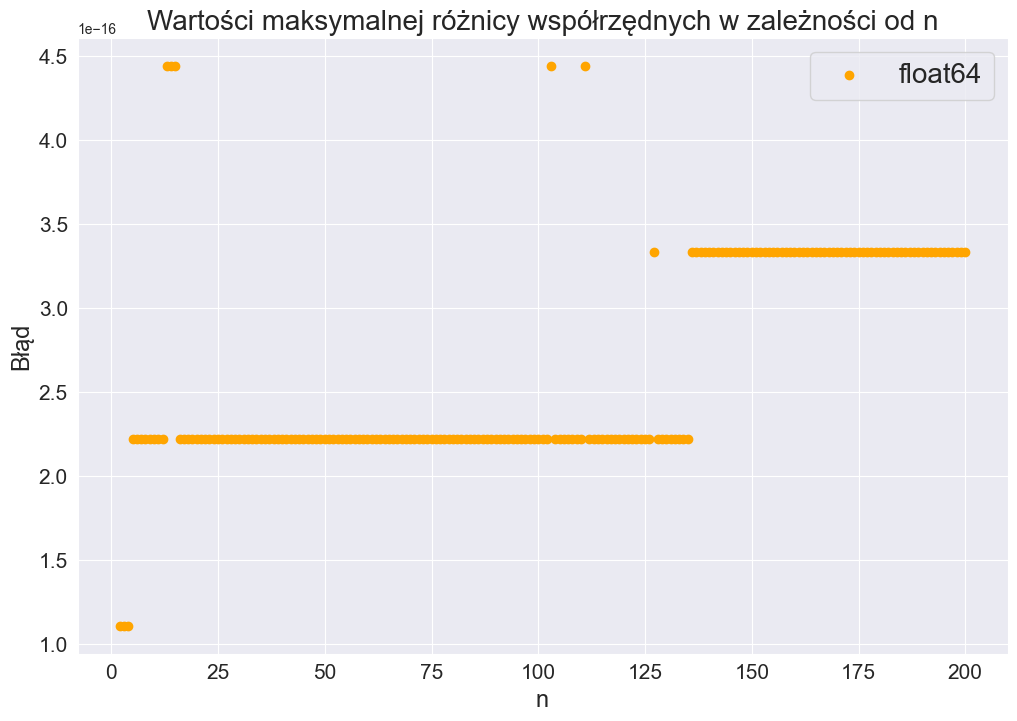

In [322]:
data_plot(data, ns, "n", "Błąd", "Wartości maksymalnej różnicy współrzędnych w zależności od n", to_display=["float64"],
          labels=["float64"],
          colors=["orange"], figsize=(12,8))


,n,float32,float64
0,2,0.000000e+00,1.110223e-16
1,3,5.960464e-08,1.110223e-16
2,4,5.960464e-08,1.570092e-16
3,5,5.960464e-08,2.482534e-16
4,6,5.960464e-08,2.482534e-16
5,7,1.332800e-07,2.719480e-16
6,8,1.788139e-07,2.719480e-16
7,9,1.788139e-07,2.719480e-16
8,10,1.884864e-07,2.937374e-16
9,11,1.884864e-07,2.937374e-16


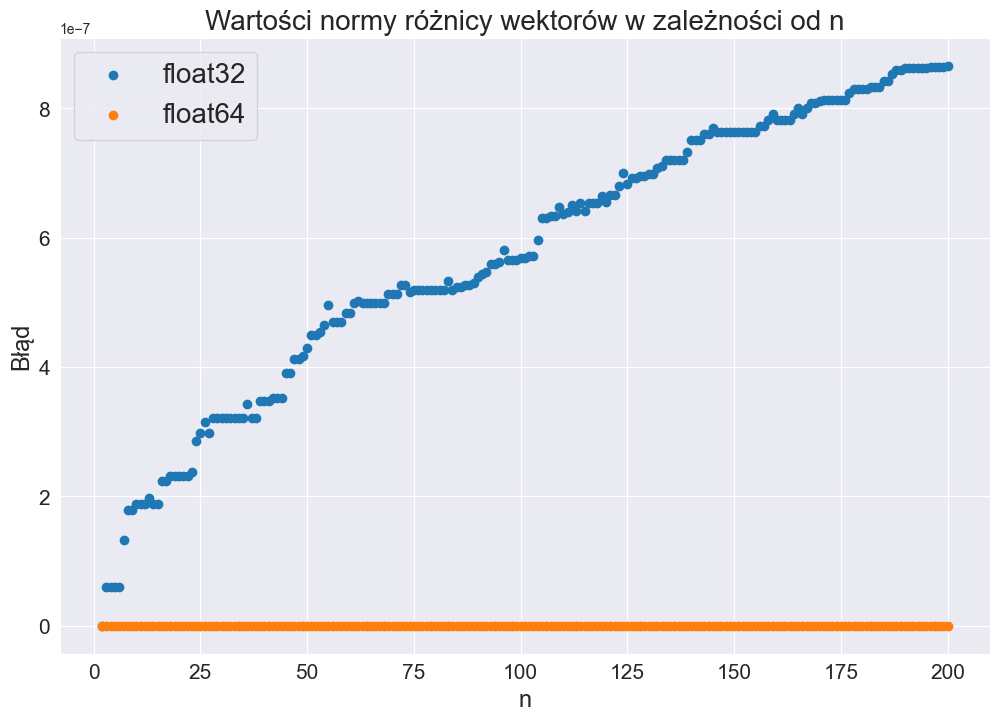

In [324]:
data = solve_and_display_errors(norm_diffrence, ns, precisions, func3)
create_table(data, ns_table)
data_plot(data, ns, "n", "Błąd", "Wartości normy różnicy wektorów w zależności od n", figsize=(12,8))

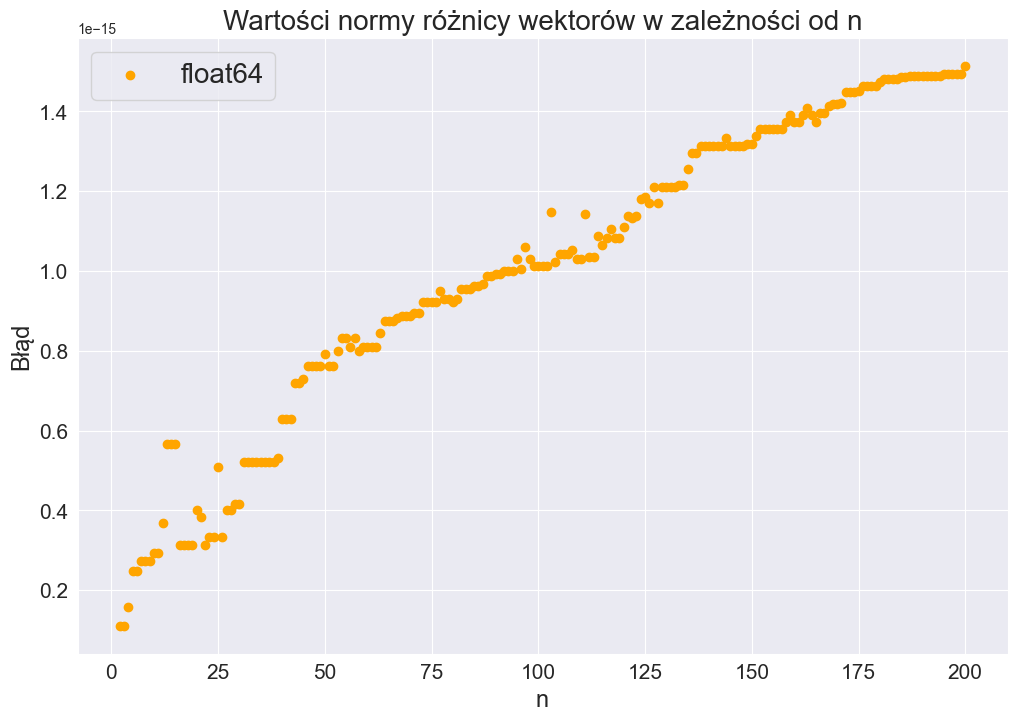

In [325]:
data_plot(data, ns, "n", "Błąd", "Wartości normy różnicy wektorów w zależności od n", to_display=["float64"], labels=["float64"],
          colors=["orange"], figsize=(12,8))

,n,float32,float64
0,2,0.000000e+00,1.110223e-16
1,3,5.960464e-08,1.110223e-16
2,4,5.960464e-08,1.110223e-16
3,5,5.960464e-08,2.220446e-16
4,6,5.960464e-08,2.220446e-16
5,7,1.192093e-07,2.220446e-16
6,8,1.192093e-07,2.220446e-16
7,9,1.192093e-07,2.220446e-16
8,10,1.192093e-07,2.220446e-16
9,11,1.192093e-07,2.220446e-16


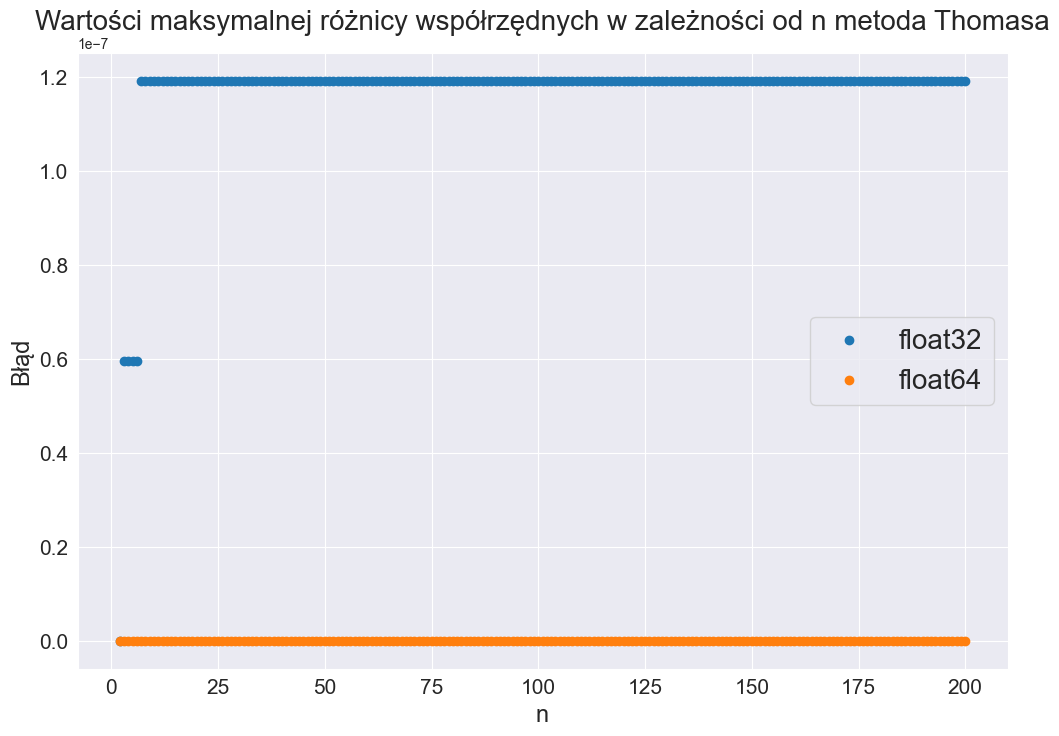

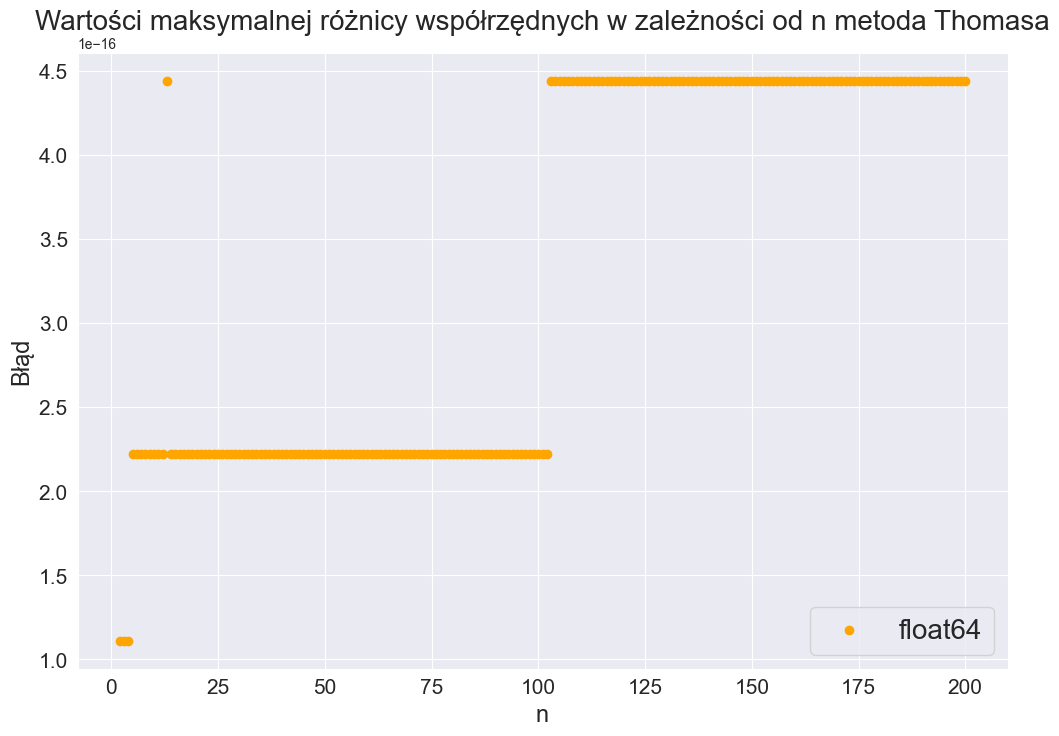

In [28]:
data = solve_and_display_errors(max_error, ns, precisions, func3, sol_method="thomas")
create_table(data, ns_table)
data_plot(data, ns, "n", "Błąd", "Wartości maksymalnej różnicy współrzędnych w zależności od n metoda Thomasa", figsize=(12,8))
data_plot(data, ns, "n", "Błąd", "Wartości maksymalnej różnicy współrzędnych w zależności od n metoda Thomasa",
          to_display=["float64"], labels=["float64"],
          colors=["orange"], figsize=(12,8))

,n,float32,float64
0,2,0.000000e+00,1.110223e-16
1,3,5.960464e-08,1.110223e-16
2,4,5.960464e-08,1.570092e-16
3,5,5.960464e-08,2.482534e-16
4,6,5.960464e-08,2.482534e-16
5,7,1.332800e-07,2.719480e-16
6,8,1.788139e-07,2.719480e-16
7,9,1.788139e-07,2.719480e-16
8,10,1.884864e-07,2.937374e-16
9,11,1.884864e-07,2.937374e-16


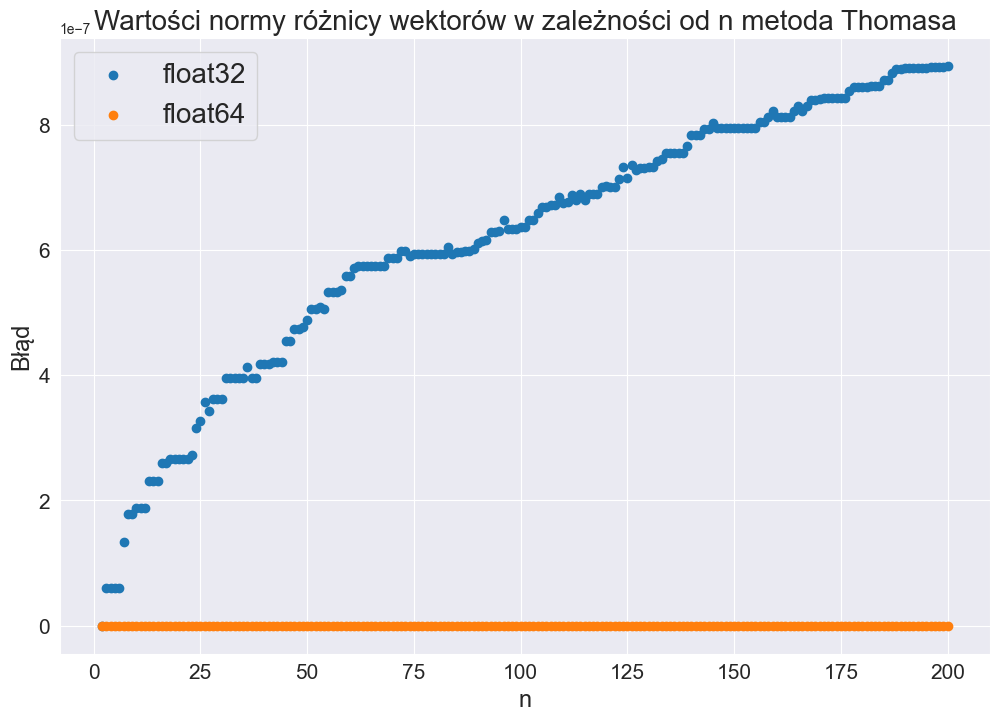

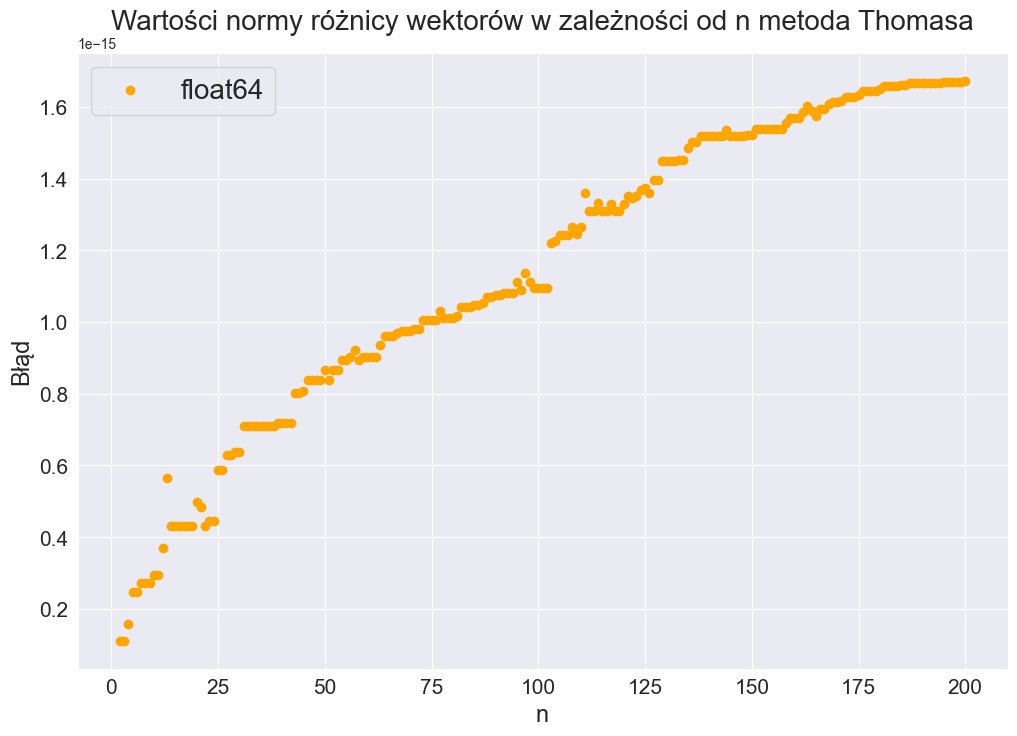

In [29]:
data = solve_and_display_errors(norm_diffrence, ns, precisions, func3, sol_method="thomas")
create_table(data, ns_table)
data_plot(data, ns, "n", "Błąd", "Wartości normy różnicy wektorów w zależności od n metoda Thomasa", figsize=(12,8))
data_plot(data, ns, "n", "Błąd", "Wartości normy różnicy wektorów w zależności od n metoda Thomasa", to_display=["float64"],
          labels=["float64"],
          colors=["orange"], figsize=(12,8))

,n,gauss_time [s],thomas_time [s],gauss_error,thomas_error
0,2,0.000097,0.000012,1.110223e-16,1.110223e-16
1,3,0.000022,0.000013,1.110223e-16,1.110223e-16
2,4,0.000032,0.000017,1.110223e-16,1.110223e-16
3,5,0.000046,0.000009,2.220446e-16,2.220446e-16
4,6,0.000074,0.000040,2.220446e-16,2.220446e-16
5,7,0.000173,0.000018,2.220446e-16,2.220446e-16
6,8,0.000218,0.000023,2.220446e-16,2.220446e-16
7,9,0.000261,0.000023,2.220446e-16,2.220446e-16
8,10,0.000308,0.000024,2.220446e-16,2.220446e-16
9,11,0.000384,0.000028,2.220446e-16,2.220446e-16


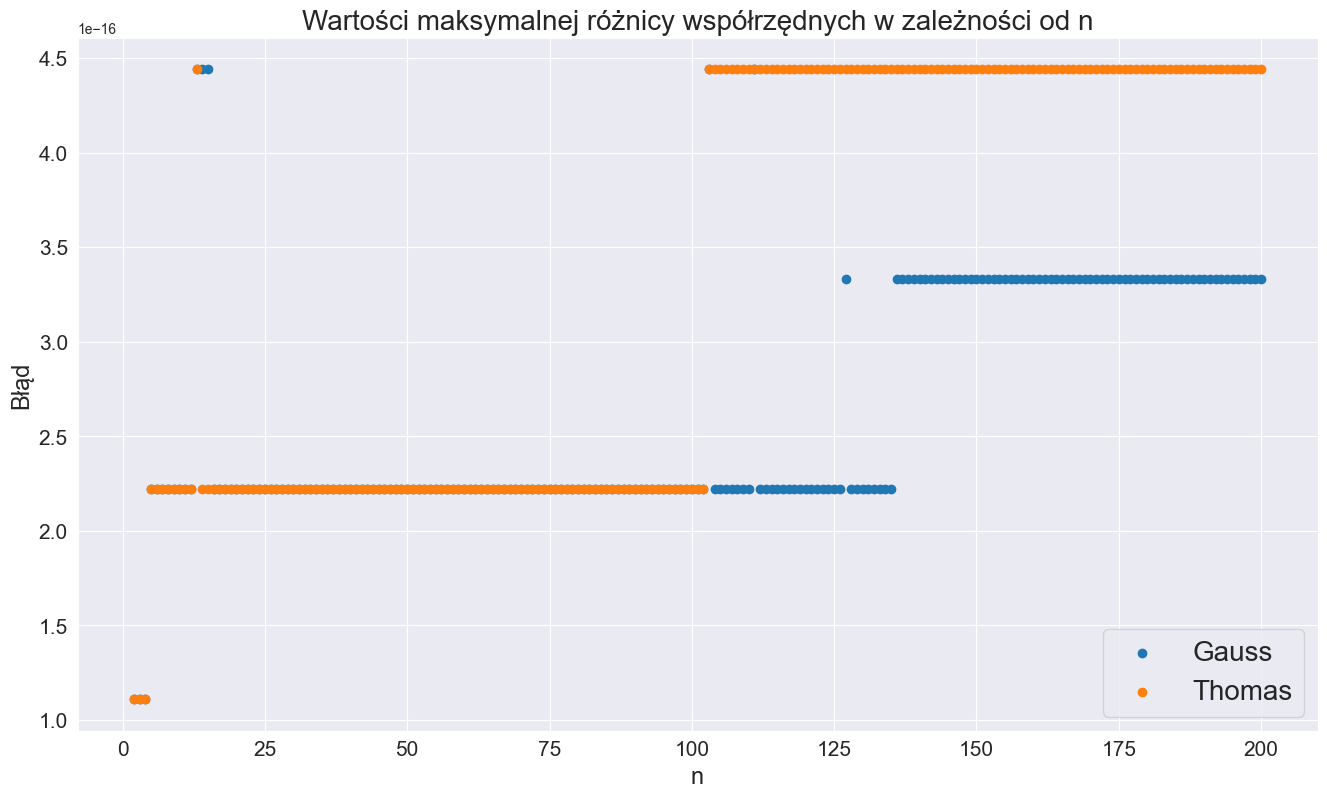

In [30]:
data = solve_and_display_times(max_error, ns, np.float64, func3)
create_table(data, ns_table)
data_plot(data, ns, "n", "Błąd", "Wartości maksymalnej różnicy współrzędnych w zależności od n",
          to_display=["gauss_error", "thomas_error"], labels=["Gauss", "Thomas"])

,n,gauss_time [s],thomas_time [s],gauss_error,thomas_error
0,2,0.000053,0.000012,1.110223e-16,1.110223e-16
1,3,0.000034,0.000012,1.110223e-16,1.110223e-16
2,4,0.000033,0.000012,1.570092e-16,1.570092e-16
3,5,0.000072,0.000017,2.482534e-16,2.482534e-16
4,6,0.000087,0.000016,2.482534e-16,2.482534e-16
5,7,0.000178,0.000029,2.719480e-16,2.719480e-16
6,8,0.000133,0.000034,2.719480e-16,2.719480e-16
7,9,0.000159,0.000017,2.719480e-16,2.719480e-16
8,10,0.000186,0.000019,2.937374e-16,2.937374e-16
9,11,0.000221,0.000019,2.937374e-16,2.937374e-16


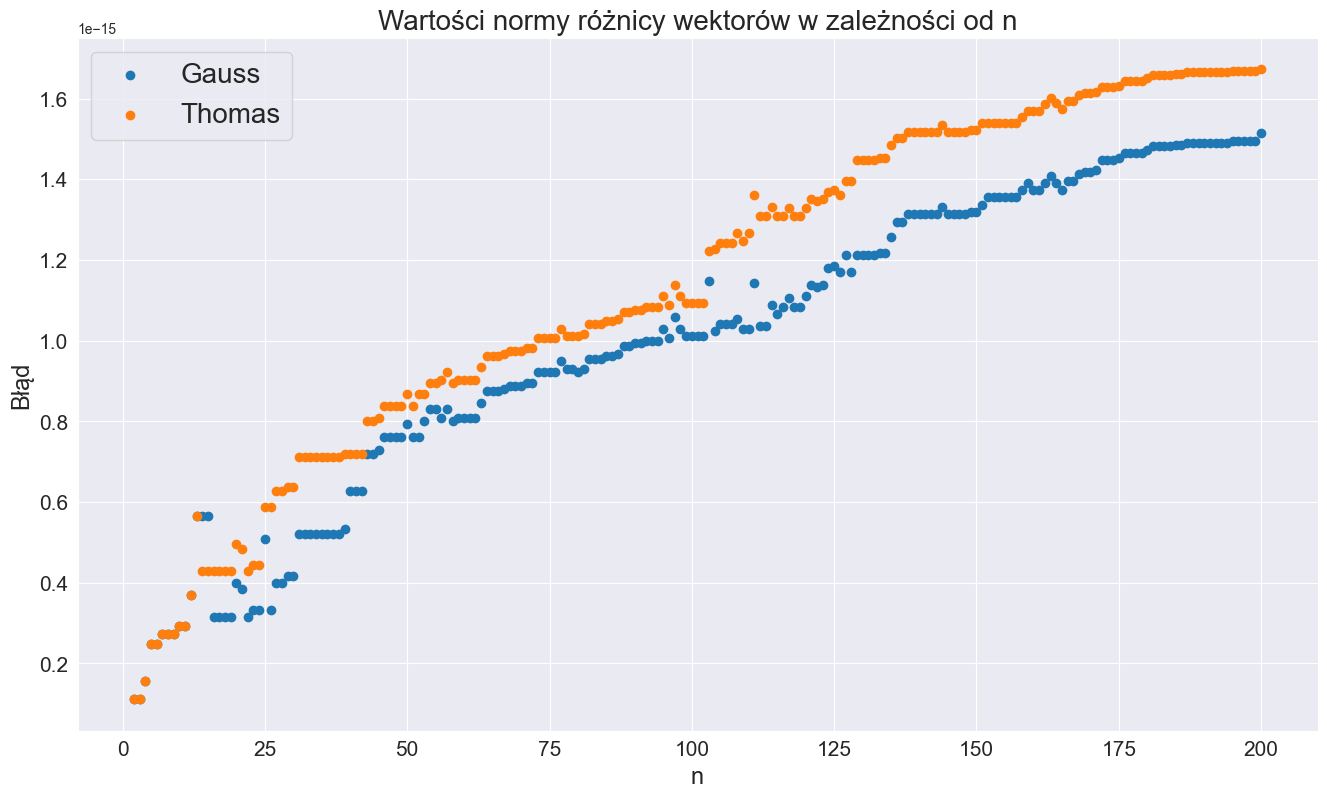

In [31]:
data = solve_and_display_times(norm_diffrence, ns, np.float64, func3)
create_table(data, ns_table)
data_plot(data, ns, "n", "Błąd", "Wartości normy różnicy wektorów w zależności od n", to_display=["gauss_error", "thomas_error"],
          labels=["Gauss",
                                                                                                           "Thomas"])

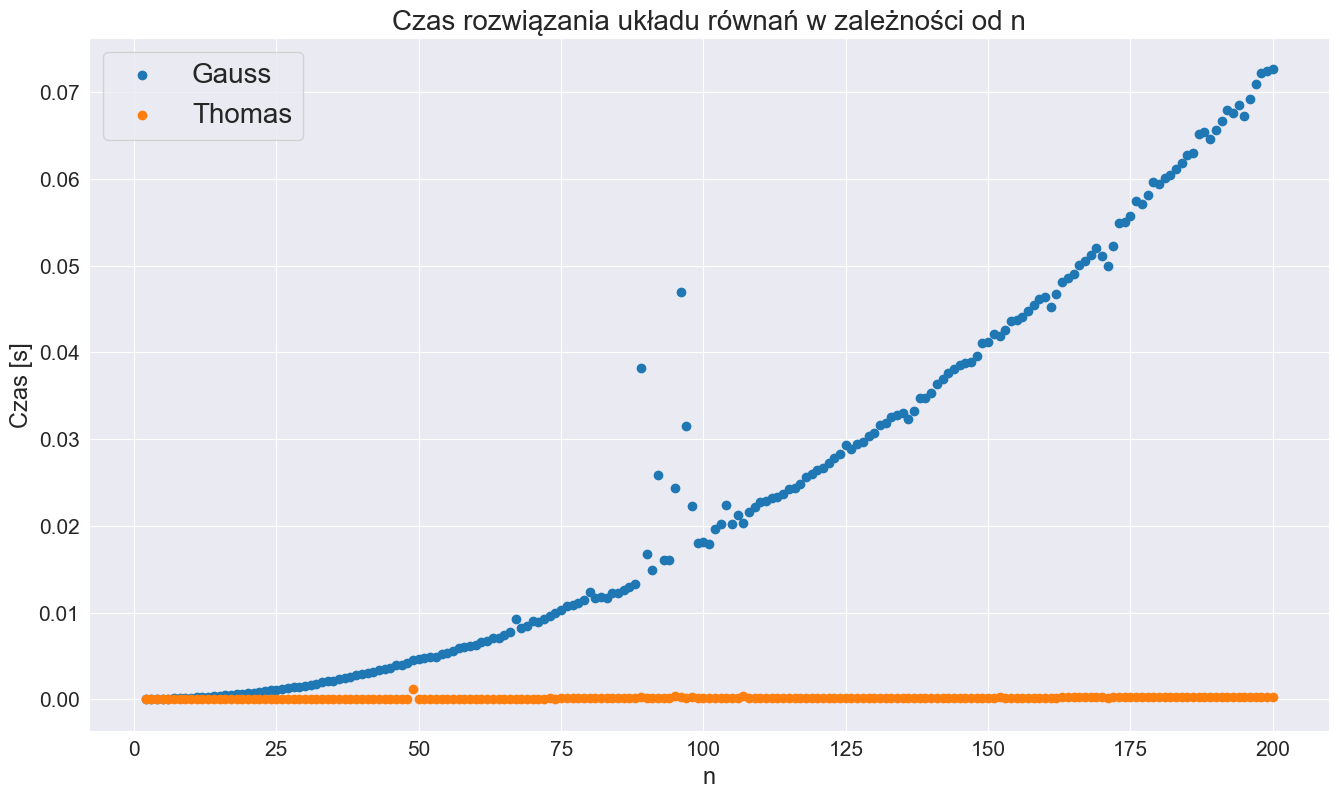

In [36]:
data_plot(data, ns, "n", "Czas [s]", "Czas rozwiązania układu równań w zależności od n", to_display=["gauss_time "
                                                                                                     "[s]",
                                                                                                     "thomas_time "
                                                                                                     "[s]"], labels=["Gauss", "Thomas"])

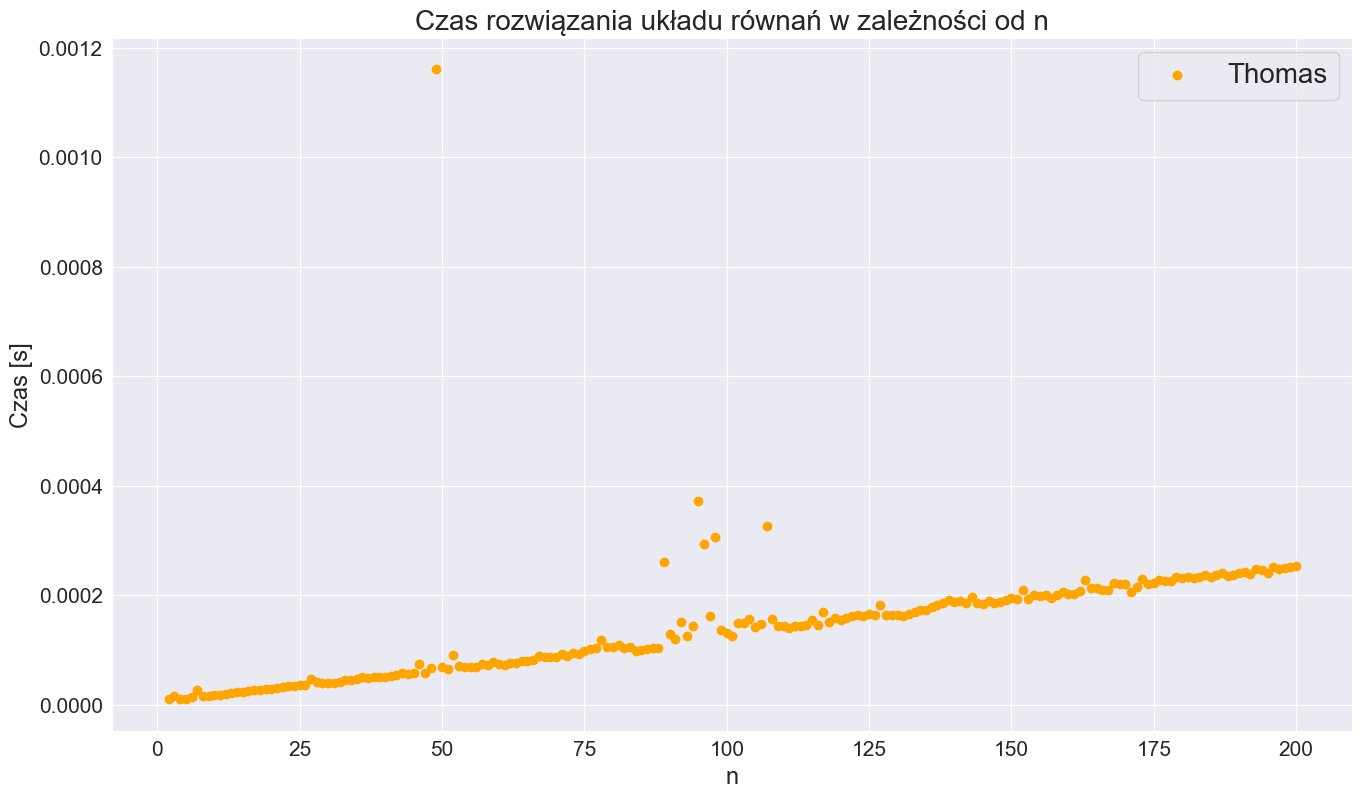

In [37]:
data_plot(data, ns, "n", "Czas [s]", "Czas rozwiązania układu równań w zależności od n", to_display=[
                                                                                                     "thomas_time "
                                                                                                     "[s]"], labels=["Thomas"],
    colors=["orange"])